In [56]:
from baselines import MODEL_WEM
import os
import pickle
import numpy as np
import time, datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint

In [39]:
DATA_SET_PATH = "/root/mounted/datasets/data_0515/"
KN_CSV = os.path.join(DATA_SET_PATH, "knowledge.csv")
TRAIN_CSV = os.path.join(DATA_SET_PATH, "train.csv")
TEST_CSV = os.path.join(DATA_SET_PATH, "test.csv")
SUBMIT_CSV = os.path.join(DATA_SET_PATH, "submit.csv")
CHAR_EMBED_PKL = os.path.join(DATA_SET_PATH, "char_embed.pkl")
WORD_EMBED_PKL = os.path.join(DATA_SET_PATH, "word_embed.pkl")
QUESTION_PKL = os.path.join(DATA_SET_PATH, "question.pkl")
INTERMEDIATE_DATA_PATH = os.path.join(DATA_SET_PATH, 'intermediate')
KN_TRAIN_CSV = os.path.join(INTERMEDIATE_DATA_PATH, 'kn_train.csv')
KN_TRAIN_WV_CV_CSV = os.path.join(INTERMEDIATE_DATA_PATH, 'kn_train_wv_cv.csv')
TEST_WV_CV_CSV = os.path.join(INTERMEDIATE_DATA_PATH, 'test_wv_cv.csv')
WEM_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'WEM.pkl')
CEM_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'CEM.pkl')
KN_TRAIN_WIDS_CIDS_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'kn_train_wids_cids.pkl')
TEST_WIDS_CIDS_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'test_wids_cids.pkl')
KN_TRAIN_WIDS_CIDS_PADDED_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'kn_train_wids_cids_padded.pkl')
TEST_WIDS_CIDS_PADDED_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'test_wids_cids_padded.pkl')

MODEL_WEIGHTS_FILE = './keras_saved_models/baseline_model_wem.h5'

WORDS_NUM = 20891
CHARS_NUM = 3048
WORD_EMBEDDING_DIM = 300
CHAR_EMBEDDING_DIM = 300

MAX_WSEQ_LEN = 39
MAX_CSEQ_LEN = 58

VALIDATION_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
BATCH_SIZE = 320

In [2]:
# 加载模型
model = MODEL_WEM()

In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 39, 300)      6267600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 39, 300)      6267600     input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

In [9]:
# 加载数据集，并切分成train 和 validation
with open(KN_TRAIN_WIDS_CIDS_PADDED_PKL, 'rb') as f:
    kn_train_wids_cids_padded = pickle.load(f)

kn_train_wids_cids_padded.head()

,qid1,qid2,words1,chars1,words2,chars2,label
0,Q131177,Q112611,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,Q336221,Q112611,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,Q659732,Q112611,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,Q686996,Q112611,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,Q630751,Q112611,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [53]:
q1_inputs = kn_train_wids_cids_padded['words1'].values
q2_inputs = kn_train_wids_cids_padded['words2'].values
inputs = np.stack((q1_inputs, q2_inputs), axis=1)
labels = kn_train_wids_cids_padded['label']
inputs_train, inputs_val, labels_train, labels_val = train_test_split(inputs, labels, test_size=VALIDATION_SPLIT, random_state=RNG_SEED)
q1_train = np.array(list(inputs_train[:,0]))
q2_train = np.array(list(inputs_train[:,1]))
q1_val = np.array(list(inputs_val[:,0]))
q2_val = np.array(list(inputs_val[:,1]))

In [35]:
inputs_train.shape, inputs_val.shape

((3644496, 2), (404944, 2))

In [51]:
np.array(list(q1_train)).shape

(3644496, 39)

In [54]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([q1_train, q2_train],
                    labels_train,
                    epochs=NB_EPOCHS,
                    validation_data = ([q1_val, q2_val], labels_val),
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-05-16 09:59:27.440120
Train on 3644496 samples, validate on 404944 samples
Epoch 1/25
 - 100s - loss: 0.0899 - acc: 0.9641 - val_loss: 0.0302 - val_acc: 0.9880
Epoch 2/25
 - 99s - loss: 0.0306 - acc: 0.9882 - val_loss: 0.0213 - val_acc: 0.9914
Epoch 3/25
 - 100s - loss: 0.0220 - acc: 0.9913 - val_loss: 0.0171 - val_acc: 0.9927
Epoch 4/25
 - 99s - loss: 0.0174 - acc: 0.9929 - val_loss: 0.0137 - val_acc: 0.9944
Epoch 5/25
 - 99s - loss: 0.0146 - acc: 0.9939 - val_loss: 0.0101 - val_acc: 0.9954
Epoch 6/25
 - 98s - loss: 0.0125 - acc: 0.9946 - val_loss: 0.0083 - val_acc: 0.9958
Epoch 7/25
 - 99s - loss: 0.0113 - acc: 0.9951 - val_loss: 0.0084 - val_acc: 0.9960
Epoch 8/25
 - 98s - loss: 0.0101 - acc: 0.9955 - val_loss: 0.0068 - val_acc: 0.9966
Epoch 9/25
 - 97s - loss: 0.0095 - acc: 0.9957 - val_loss: 0.0080 - val_acc: 0.9960
Epoch 10/25
 - 98s - loss: 0.0088 - acc: 0.9959 - val_loss: 0.0056 - val_acc: 0.9968
Epoch 11/25
 - 100s - loss: 0.0083 - acc: 0.9961 - val_l

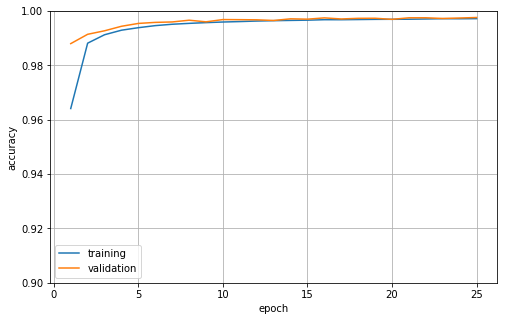

In [69]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.iloc[:,:].plot(x='epoch', figsize=(8,5), grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.9,1.0]);

In [71]:
with open(TEST_WIDS_CIDS_PADDED_PKL, 'rb') as f:
    test_wids_cids_padded = pickle.load(f)
    
test_wids_cids_padded.head()

,qid1,qid2,words1,chars1,words2,chars2
0,Q345287,Q329078,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Q227821,Q460114,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Q449509,Q525440,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Q088371,Q364132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Q163532,Q114092,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [91]:
q1_test_inputs = np.array(list(test_wids_cids_padded['words1'].values))
q2_test_inputs = np.array(list(test_wids_cids_padded['words2'].values))
q1_test_inputs.shape

(24090, 39)

In [108]:
# 直接用最后一个epoch的模型
test_pred1 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred1 = test_pred1.squeeze()
test_pred1

array([9.9999940e-01, 9.9999917e-01, 9.4351268e-01, ..., 3.9091287e-07,
       1.0879915e-03, 6.8555243e-04], dtype=float32)

In [98]:
max(test_pred1), sum(test_pred1), sum(test_pred1) / 24090

(array([1.], dtype=float32),
 array([8436.729], dtype=float32),
 array([0.35021704], dtype=float32))

In [114]:
test_pred1_df = pd.DataFrame({'y_pre':test_pred1})
test_pred1_df

,y_pre
0,9.999994e-01
1,9.999992e-01
2,9.435127e-01
3,1.345569e-03
4,7.305108e-01
5,1.203072e-05
6,2.308235e-05
7,4.079857e-07
8,7.469954e-08
9,1.441542e-05


In [115]:
TEST_PRED_1 = './predicts/test_pred1.csv'
test_pred1_df.to_csv(TEST_PRED_1, index=False)

In [116]:
model.load_weights(MODEL_WEIGHTS_FILE)
test_pred2 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred2 = test_pred2.squeeze()
test_pred2

array([9.9999940e-01, 9.9999917e-01, 9.4351268e-01, ..., 3.9091287e-07,
       1.0879915e-03, 6.8555243e-04], dtype=float32)

In [119]:
diff = test_pred2 - test_pred1
max(diff), sum(diff), sum(diff)/24090

(0.0, 0.0, 0.0)